In [3]:
import pandas as pd
import datetime as dt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from RandomForestForTimeSeriesClassifier import RandomForestForTimeSeriesClassifier, BLOCK_TYPES
from pyts.classification import TimeSeriesForest

In [4]:
dataset = pd.read_csv('../datasets/sp_500_stocks/sp500_stocks.csv') #, nrows=1000000)

In [5]:
dataset = dataset.dropna()
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
22524,2010-01-04,AMD,9.700000,9.700000,9.900000,9.680000,9.790000,18748700.0
22525,2010-01-05,AMD,9.710000,9.710000,9.900000,9.680000,9.710000,22145700.0
22526,2010-01-06,AMD,9.570000,9.570000,9.760000,9.550000,9.680000,18643400.0
22527,2010-01-07,AMD,9.470000,9.470000,9.550000,9.180000,9.510000,26806800.0
22528,2010-01-08,AMD,9.430000,9.430000,9.470000,9.290000,9.370000,13752800.0
...,...,...,...,...,...,...,...,...
1880749,2024-11-25,ZBRA,400.940002,400.940002,404.320007,398.130005,400.029999,420200.0
1880750,2024-11-26,ZBRA,402.450012,402.450012,403.570007,399.690002,402.440002,369200.0
1880751,2024-11-27,ZBRA,405.750000,405.750000,406.140015,400.929993,403.730011,258300.0
1880752,2024-11-29,ZBRA,407.000000,407.000000,409.029999,405.510010,406.640015,175700.0


In [6]:
dataset = dataset.loc[(dataset['Symbol'] == "AAPL") | (dataset['Symbol'] == "JNJ") | (dataset['Symbol'] == "JPM") | (dataset['Symbol'] == "XOM") | (dataset['Symbol'] == "PG") | (dataset['Symbol'] == "HD") | (dataset['Symbol'] == "T") | (dataset['Symbol'] == "UNP") | (dataset['Symbol'] == "DUK") | (dataset['Symbol'] == "AMT") | (dataset['Symbol'] == "MDLZ")]

In [7]:
dataset = dataset.sort_values("Date")
dataset

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
108866,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0
1006072,2010-01-04,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0
108867,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0
1006073,2010-01-05,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0
108868,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0
...,...,...,...,...,...,...,...,...
112617,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0
1009824,2024-11-29,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0
112618,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0
112619,2024-12-02,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0


In [8]:
dateFormat = "%Y-%m-%d"

def calculateAvgVolatility(row0, days, dateList, volatilityHistory, volatility):
    if len(dateList) == 0:
        dateList.append(row0['Date'])
        volatilityHistory.append((row0['High'] - row0['Low']) / row0['Low'])
    else:
        pivoteDate = dateList[0]

        listVoid = False
        while dt.datetime.strptime(pivoteDate, dateFormat) + dt.timedelta(days=days) <= dt.datetime.strptime(row0['Date'], dateFormat) and not listVoid:
            dateList.pop(0)
            volatilityHistory.pop(0)
            if len(dateList) > 0:
                pivoteDate = dateList[0]
            else:
                listVoid = True

        dateList.append(row0['Date'])
        volatilityHistory.append((row0['High'] - row0['Low']) / row0['Low'])
    volatility.append(sum(volatilityHistory) / len(volatilityHistory))

In [9]:
groupedBySymbol = dataset.groupby('Symbol')

symbols = []
dates = []
volatility14 = []
volatility30 = []
volatility90 = []
#datetime.strptime(date, format) + timedelta(days=days) > datetime.today()
for symbol, group0 in groupedBySymbol:
    group0 = group0.reset_index()  # make sure indexes pair with number of rows
    datesIn14Days = []
    datesIn30Days = []
    datesIn90Days = []
    volatility14History = []
    volatility30History = []
    volatility90History = []

    for index, row in group0.iterrows():

        symbols.append(symbol)
        dates.append(row["Date"])

        calculateAvgVolatility(row, 14, datesIn14Days, volatility14History, volatility14)
        calculateAvgVolatility(row, 30, datesIn30Days, volatility30History, volatility30)
        calculateAvgVolatility(row, 90, datesIn90Days, volatility90History, volatility90)


In [10]:
data = {
    'Symbol': symbols,
    'Date': dates,
    'Volatility14': volatility14,
    'Volatility30': volatility30,
    'Volatility90': volatility90,
}

dfVolatility = pd.DataFrame(data)
new_df = pd.merge(
    left=dataset,
    right=dfVolatility,
    how='left',
    left_on=['Date', 'Symbol'],
    right_on=['Date', 'Symbol'],
)
new_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Volatility14,Volatility30,Volatility90
0,2010-01-04,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0,0.014094,0.014094,0.014094
1,2010-01-04,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0,0.031678,0.031678,0.031678
2,2010-01-05,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0,0.016840,0.016840,0.016840
3,2010-01-05,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0,0.028228,0.028228,0.028228
4,2010-01-06,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0,0.017243,0.017243,0.017243
...,...,...,...,...,...,...,...,...,...,...,...
7503,2024-11-27,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0,0.016718,0.023014,0.020162
7504,2024-11-29,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0,0.016835,0.019024,0.019613
7505,2024-11-29,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0,0.016165,0.021675,0.020028
7506,2024-12-02,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0,0.014827,0.019972,0.019612


In [11]:
new_df['Date'] = pd.to_datetime(new_df['Date'])
new_df['Date'] = new_df['Date'].map(dt.datetime.toordinal)
new_df

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume,Volatility14,Volatility30,Volatility90
0,733776,AMT,33.184425,43.459999,43.889999,43.279999,43.490002,2750500.0,0.014094,0.014094,0.014094
1,733776,JPM,29.156572,42.849998,42.990002,41.669998,41.790001,35460500.0,0.031678,0.031678,0.031678
2,733777,AMT,33.734184,44.180000,44.250000,43.400002,43.500000,2575800.0,0.016840,0.016840,0.016840
3,733777,JPM,29.721331,43.680000,43.840000,42.779999,42.790001,41208300.0,0.028228,0.028228,0.028228
4,733778,AMT,33.909798,44.410000,44.560001,43.770000,44.240002,3215300.0,0.017243,0.017243,0.017243
...,...,...,...,...,...,...,...,...,...,...,...
7503,739217,AMT,209.300003,209.300003,209.669998,207.830002,208.000000,1669400.0,0.016718,0.023014,0.020162
7504,739219,JPM,249.720001,249.720001,251.770004,249.449997,249.860001,5494800.0,0.016835,0.019024,0.019613
7505,739219,AMT,209.000000,209.000000,209.770004,207.529999,209.300003,1610200.0,0.016165,0.021675,0.020028
7506,739222,AMT,207.330002,207.330002,208.509995,205.710007,207.539993,2363317.0,0.014827,0.019972,0.019612


In [12]:
from sklearn import preprocessing

Y = new_df.pop("Symbol")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(new_df)
normalized_dataset = pd.DataFrame(x_scaled)

normalized_dataset

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.052122,0.054789,0.053753,0.057038,0.055570,0.010440,0.057551,0.056256,0.067904
1,0.000000,0.036432,0.052572,0.050475,0.051087,0.049371,0.161312,0.215498,0.276319,0.478510
2,0.000184,0.054263,0.057404,0.055064,0.057482,0.055606,0.009634,0.082213,0.090617,0.132016
3,0.000184,0.038632,0.055588,0.053571,0.055190,0.053017,0.187823,0.184509,0.233143,0.397950
4,0.000367,0.054948,0.058240,0.056193,0.058850,0.058304,0.012584,0.085833,0.095661,0.141428
...,...,...,...,...,...,...,...,...,...,...
7503,0.999082,0.738155,0.657317,0.657489,0.665311,0.655424,0.005454,0.081117,0.167896,0.209590
7504,0.999449,0.895605,0.804171,0.810809,0.819163,0.808058,0.023098,0.082170,0.117951,0.196780
7505,0.999449,0.736986,0.656227,0.657854,0.664202,0.660164,0.005181,0.076151,0.151138,0.206476
7506,1.000000,0.730481,0.650160,0.653265,0.657475,0.653747,0.008654,0.064132,0.129819,0.196748


In [14]:
trainPercent = 80
trainSamples = (len(dataset.index) // 100) * trainPercent
testSamples = len(dataset.index) - trainSamples

In [15]:
aux = normalized_dataset.copy()

#Y = aux.pop("Symbol")

X = aux.copy()
#dataset = aux

X_train = X.iloc[:trainSamples]
Y_train = Y.iloc[:trainSamples]
X_test = X.iloc[-testSamples:]
Y_test = Y.iloc[-testSamples:]

#X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=1)
#
#X_train = X_train.values.reshape(-1, 1)
#X_test = X_test.values.reshape(-1, 1)
X_train

,0,1,2,3,4,5,6,7,8,9
0,0.000000,0.052122,0.054789,0.053753,0.057038,0.055570,0.010440,0.057551,0.056256,0.067904
1,0.000000,0.036432,0.052572,0.050475,0.051087,0.049371,0.161312,0.215498,0.276319,0.478510
2,0.000184,0.054263,0.057404,0.055064,0.057482,0.055606,0.009634,0.082213,0.090617,0.132016
3,0.000184,0.038632,0.055588,0.053571,0.055190,0.053017,0.187823,0.184509,0.233143,0.397950
4,0.000367,0.054948,0.058240,0.056193,0.058850,0.058304,0.012584,0.085833,0.095661,0.141428
...,...,...,...,...,...,...,...,...,...,...
5995,0.798201,0.874288,0.866735,0.874686,0.863670,0.860091,0.006254,0.119960,0.149377,0.204009
5996,0.798384,0.491682,0.473950,0.478896,0.482182,0.477338,0.085032,0.100263,0.080349,0.147210
5997,0.798384,0.858392,0.850531,0.870461,0.866886,0.860201,0.010482,0.127708,0.149696,0.204001
5998,0.798568,0.845810,0.837705,0.868240,0.852654,0.859544,0.009880,0.140236,0.155960,0.210420


In [16]:
from sklearn import metrics

basicRFPrecision = []
for i in range(50):
    basicRF = RandomForestClassifier(n_jobs=10, n_estimators=500, max_depth=10)
    basicRF.fit(X_train, Y_train)
    y_pred = basicRF.predict(X_test)
    print(f"Precisión:")
    print(metrics.accuracy_score(Y_test, y_pred))
    basicRFPrecision.append(metrics.accuracy_score(Y_test, y_pred))

Precisión:
0.8587533156498673
Precisión:
0.860079575596817
Precisión:
0.8594164456233422
Precisión:
0.9098143236074271
Precisión:
0.8746684350132626
Precisión:
0.8620689655172413
Precisión:
0.8587533156498673
Precisión:
0.8587533156498673
Precisión:
0.919761273209549
Precisión:
0.8594164456233422
Precisión:
0.9608753315649867
Precisión:
0.9370026525198939
Precisión:
0.8594164456233422
Precisión:
0.9343501326259946
Precisión:
0.9071618037135278
Precisión:
0.8594164456233422
Precisión:
0.8846153846153846
Precisión:
0.9051724137931034
Precisión:
0.9356763925729443
Precisión:
0.8594164456233422
Precisión:
0.9370026525198939
Precisión:
0.916445623342175
Precisión:
0.9224137931034483
Precisión:
0.9330238726790451
Precisión:
0.9568965517241379
Precisión:
0.8587533156498673
Precisión:
0.9310344827586207
Precisión:
0.9124668435013262
Precisión:
0.9356763925729443
Precisión:
0.8925729442970822
Precisión:
0.9383289124668435
Precisión:
0.9263925729442971
Precisión:
0.9555702917771883
Precisión:
0.

In [18]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [22]:
precisionNonOverlapping = dict()
for i in [10, 20, 30]:
    precisionNonOverlapping[i] = []
    block_size = i #int(count_row // i)
    for k in range(50):
        rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        print(f"Precisión: ({i}, {k})")
        print(metrics.accuracy_score(Y_test, y_pred))
        precisionNonOverlapping[i].append(metrics.accuracy_score(Y_test, y_pred))

Precisión: (10, 0)
0.870026525198939
Precisión: (10, 1)
0.8647214854111406
Precisión: (10, 2)
0.9622015915119363
Precisión: (10, 3)
0.8587533156498673
Precisión: (10, 4)
0.9602122015915119
Precisión: (10, 5)
0.8580901856763926
Precisión: (10, 6)
0.9283819628647215
Precisión: (10, 7)
0.8587533156498673
Precisión: (10, 8)
0.896551724137931
Precisión: (10, 9)
0.9343501326259946
Precisión: (10, 10)
0.8587533156498673
Precisión: (10, 11)
0.8574270557029178
Precisión: (10, 12)
0.8587533156498673
Precisión: (10, 13)
0.8587533156498673
Precisión: (10, 14)
0.860079575596817
Precisión: (10, 15)
0.8740053050397878
Precisión: (10, 16)
0.9303713527851459
Precisión: (10, 17)
0.8978779840848806
Precisión: (10, 18)
0.8594164456233422
Precisión: (10, 19)
0.8594164456233422
Precisión: (10, 20)
0.8587533156498673
Precisión: (10, 21)
0.8812997347480106
Precisión: (10, 22)
0.8740053050397878
Precisión: (10, 23)
0.8587533156498673
Precisión: (10, 24)
0.9542440318302388
Precisión: (10, 25)
0.9171087533156499

([<matplotlib.axis.XTick at 0x20c52f74c50>,
 [Text(0, 0, '10'),
  Text(1, 0, '20'),
  Text(2, 0, '30'),
  Text(3, 0, 'Random Forest')])

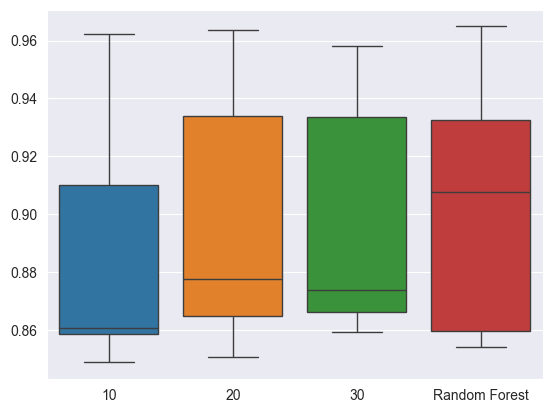

In [25]:
from matplotlib import pyplot as plt

data1 = []
for r in precisionNonOverlapping[10]:
    data1.append(r)
data2 = []
for r in precisionNonOverlapping[20]:
    data2.append(r)
data3 = []
for r in precisionNonOverlapping[30]:
    data3.append(r)

all_arr = [data1,
           data2,
           data3,
           basicRFPrecision]
sns.boxplot(data=all_arr)
plt.xticks([0, 1, 2, 3], ["10", "20", "30", "Random Forest"])

In [27]:
precisionNonOverlapping = dict()
for i in [50, 100, 200, 300, 400, 500, 1000]:
    precisionNonOverlapping[i] = []
    block_size = i #int(count_row // i)
    for k in range(50):
        rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=block_size, max_depth=10)
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        print(f"Precisión: ({i}, {k})")
        print(metrics.accuracy_score(Y_test, y_pred))
        precisionNonOverlapping[i].append(metrics.accuracy_score(Y_test, y_pred))

Precisión: (50, 0)
0.9529177718832891
Precisión: (50, 1)
0.8806366047745358
Precisión: (50, 2)
0.9641909814323607
Precisión: (50, 3)
0.9535809018567639
Precisión: (50, 4)
0.9131299734748011
Precisión: (50, 5)
0.8647214854111406
Precisión: (50, 6)
0.9515915119363395
Precisión: (50, 7)
0.9025198938992043
Precisión: (50, 8)
0.9482758620689655
Precisión: (50, 9)
0.9297082228116711
Precisión: (50, 10)
0.9104774535809018
Precisión: (50, 11)
0.8687002652519894
Precisión: (50, 12)
0.9496021220159151
Precisión: (50, 13)
0.9555702917771883
Precisión: (50, 14)
0.9383289124668435
Precisión: (50, 15)
0.9529177718832891
Precisión: (50, 16)
0.8740053050397878
Precisión: (50, 17)
0.9330238726790451
Precisión: (50, 18)
0.9575596816976127
Precisión: (50, 19)
0.9595490716180372
Precisión: (50, 20)
0.8826259946949602
Precisión: (50, 21)
0.9336870026525199
Precisión: (50, 22)
0.8673740053050398
Precisión: (50, 23)
0.9542440318302388
Precisión: (50, 24)
0.9177718832891246
Precisión: (50, 25)
0.8660477453580

Text(0, 0.5, 'Precisión')

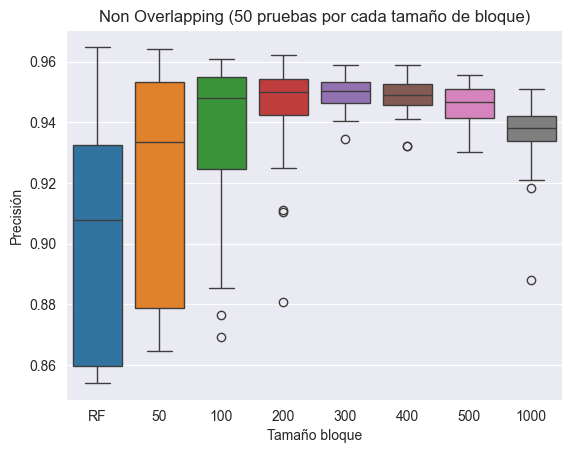

In [55]:
from matplotlib import pyplot as plt

data0 = []
for r in precisionNonOverlapping[50]:
    data0.append(r)
data1 = []
for r in precisionNonOverlapping[100]:
    data1.append(r)
data2 = []
for r in precisionNonOverlapping[200]:
    data2.append(r)
data3 = []
for r in precisionNonOverlapping[300]:
    data3.append(r)
data4 = []
for r in precisionNonOverlapping[400]:
    data4.append(r)
data5 = []
for r in precisionNonOverlapping[500]:
    data5.append(r)
data6 = []
for r in precisionNonOverlapping[1000]:
    data6.append(r)

all_arr = [basicRFPrecision,
           data0,
           data1,
           data2,
           data3,
           data4,
           data5,
           data6]
sns.boxplot(data=all_arr)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["RF", "50", "100", "200", "300", "400", "500", "1000"])
plt.title("Non Overlapping (50 pruebas por cada tamaño de bloque)")
plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")

In [46]:
precisionMovingBlock = dict()
for i in [50, 100, 200, 300, 400, 500, 1000]:
    precisionMovingBlock[i] = []
    block_size = i #int(count_row // i)
    for k in range(50):
        rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        print(f"Precisión: ({i}, {k})")
        print(metrics.accuracy_score(Y_test, y_pred))
        precisionMovingBlock[i].append(metrics.accuracy_score(Y_test, y_pred))

Precisión: (50, 0)
0.9535809018567639
Precisión: (50, 1)
0.8753315649867374
Precisión: (50, 2)
0.9515915119363395
Precisión: (50, 3)
0.9595490716180372
Precisión: (50, 4)
0.9588859416445623
Precisión: (50, 5)
0.9535809018567639
Precisión: (50, 6)
0.9555702917771883
Precisión: (50, 7)
0.8852785145888594
Precisión: (50, 8)
0.9575596816976127
Precisión: (50, 9)
0.9549071618037135
Precisión: (50, 10)
0.9615384615384616
Precisión: (50, 11)
0.9641909814323607
Precisión: (50, 12)
0.883289124668435
Precisión: (50, 13)
0.9549071618037135
Precisión: (50, 14)
0.9310344827586207
Precisión: (50, 15)
0.8726790450928382
Precisión: (50, 16)
0.903183023872679
Precisión: (50, 17)
0.963527851458886
Precisión: (50, 18)
0.9608753315649867
Precisión: (50, 19)
0.9542440318302388
Precisión: (50, 20)
0.9409814323607427
Precisión: (50, 21)
0.9436339522546419
Precisión: (50, 22)
0.9575596816976127
Precisión: (50, 23)
0.9363395225464191
Precisión: (50, 24)
0.916445623342175
Precisión: (50, 25)
0.9568965517241379


Text(0, 0.5, 'Precisión')

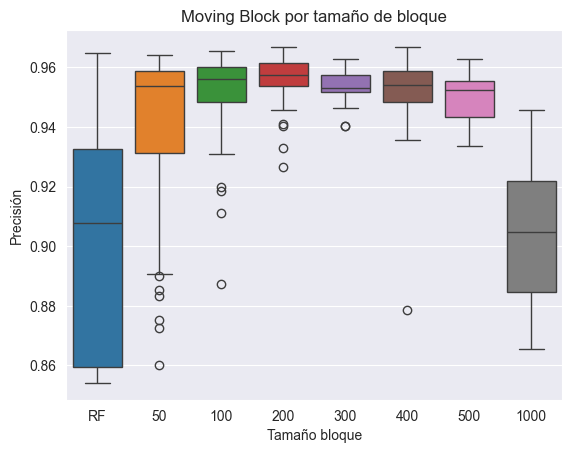

In [54]:
data0 = []
for r in precisionMovingBlock[50]:
    data0.append(r)
data1 = []
for r in precisionMovingBlock[100]:
    data1.append(r)
data2 = []
for r in precisionMovingBlock[200]:
    data2.append(r)
data3 = []
for r in precisionMovingBlock[300]:
    data3.append(r)
data4 = []
for r in precisionMovingBlock[400]:
    data4.append(r)
data5 = []
for r in precisionMovingBlock[500]:
    data5.append(r)
data6 = []
for r in precisionMovingBlock[1000]:
    data6.append(r)

all_arr1 = [basicRFPrecision,
           data0,
           data1,
           data2,
           data3,
           data4,
           data5,
           data6]
sns.boxplot(data=all_arr1)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["RF", "50", "100", "200", "300", "400", "500", "1000"])
plt.title("Moving Block por tamaño de bloque")
plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")

In [47]:
precisionCircularBlock = dict()
for i in [50, 100, 200, 300, 400, 500, 1000]:
    precisionCircularBlock[i] = []
    block_size = i #int(count_row // i)
    for k in range(50):
        rfts = RandomForestForTimeSeriesClassifier(n_jobs=10, n_estimators=500, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
        rfts.fit(X_train, Y_train)
        y_pred = rfts.predict(X_test)
        print(f"Precisión: ({i}, {k})")
        print(metrics.accuracy_score(Y_test, y_pred))
        precisionCircularBlock[i].append(metrics.accuracy_score(Y_test, y_pred))

Precisión: (50, 0)
0.9051724137931034
Precisión: (50, 1)
0.9575596816976127
Precisión: (50, 2)
0.8680371352785146
Precisión: (50, 3)
0.9542440318302388
Precisión: (50, 4)
0.9350132625994695
Precisión: (50, 5)
0.9602122015915119
Precisión: (50, 6)
0.9562334217506632
Precisión: (50, 7)
0.9038461538461539
Precisión: (50, 8)
0.9641909814323607
Precisión: (50, 9)
0.9376657824933687
Precisión: (50, 10)
0.9608753315649867
Precisión: (50, 11)
0.9310344827586207
Precisión: (50, 12)
0.9535809018567639
Precisión: (50, 13)
0.9582228116710876
Precisión: (50, 14)
0.8740053050397878
Precisión: (50, 15)
0.9244031830238727
Precisión: (50, 16)
0.9549071618037135
Precisión: (50, 17)
0.9416445623342176
Precisión: (50, 18)
0.8713527851458885
Precisión: (50, 19)
0.9509283819628647
Precisión: (50, 20)
0.9628647214854111
Precisión: (50, 21)
0.9496021220159151
Precisión: (50, 22)
0.9383289124668435
Precisión: (50, 23)
0.9363395225464191
Precisión: (50, 24)
0.9270557029177718
Precisión: (50, 25)
0.9456233421750

Text(0, 0.5, 'Precisión')

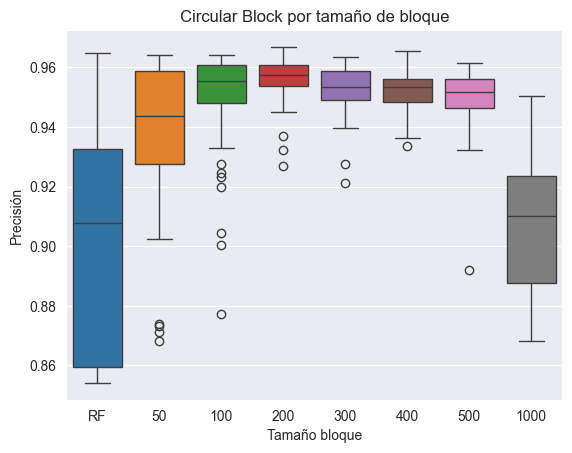

In [53]:
data0 = []
for r in precisionCircularBlock[50]:
    data0.append(r)
data1 = []
for r in precisionCircularBlock[100]:
    data1.append(r)
data2 = []
for r in precisionCircularBlock[200]:
    data2.append(r)
data3 = []
for r in precisionCircularBlock[300]:
    data3.append(r)
data4 = []
for r in precisionCircularBlock[400]:
    data4.append(r)
data5 = []
for r in precisionCircularBlock[500]:
    data5.append(r)
data6 = []
for r in precisionCircularBlock[1000]:
    data6.append(r)

all_arr2 = [basicRFPrecision,
           data0,
           data1,
           data2,
           data3,
           data4,
           data5,
           data6]
sns.boxplot(data=all_arr2)
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7], ["RF", "50", "100", "200", "300", "400", "500", "1000"])
plt.title("Circular Block por tamaño de bloque")
plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")

Text(37.597222222222214, 0.5, 'Precisión')

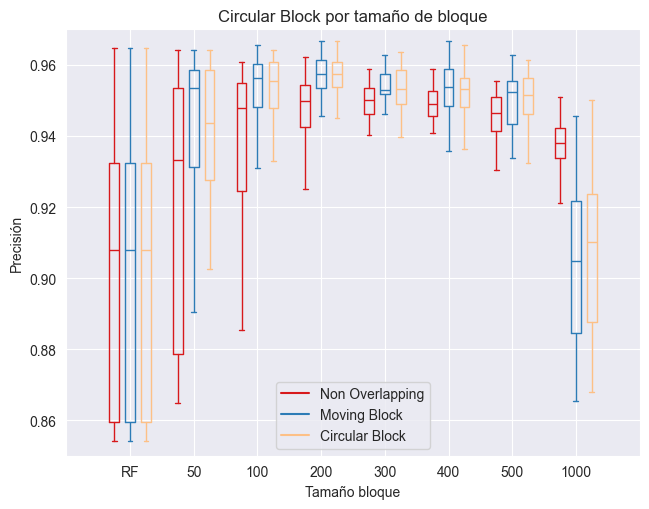

In [67]:
import numpy as np

ticks = ["RF", "50", "100", "200", "300", "400", "500", "1000"]
def set_box_color(bp, color):
    plt.setp(bp['boxes'], color=color)
    plt.setp(bp['whiskers'], color=color)
    plt.setp(bp['caps'], color=color)
    plt.setp(bp['medians'], color=color)

plt.figure()

bp0 = plt.boxplot(all_arr, positions=np.array(range(len(all_arr)))*2.0-0.5, sym='', widths=0.3)
bp1 = plt.boxplot(all_arr1, positions=np.array(range(len(all_arr1)))*2.0, sym='', widths=0.3)
bp2 = plt.boxplot(all_arr2, positions=np.array(range(len(all_arr1)))*2.0+0.5, sym='', widths=0.3)
set_box_color(bp0, '#D7191C') # colors are from http://colorbrewer2.org/
set_box_color(bp1, '#2C7BB6')
set_box_color(bp2, '#fdc086')

# draw temporary red and blue lines and use them to create a legend
plt.plot([], c='#D7191C', label='Non Overlapping')
plt.plot([], c='#2C7BB6', label='Moving Block')
plt.plot([], c='#fdc086', label='Circular Block')
plt.legend()

plt.xticks(range(0, len(ticks) * 2, 2), ticks)
plt.xlim(-2, len(ticks)*2)
plt.ylim(0.85, 0.97)
plt.tight_layout()
plt.title("Circular Block por tamaño de bloque")
plt.xlabel("Tamaño bloque")
plt.ylabel("Precisión")